In [9]:
using Turing
using LimberJack
using CSV
using NPZ
using FITSIO
using LinearAlgebra
using PythonCall
using ForwardDiff
np = pyimport("numpy")

Python module: <module 'numpy' from '/home/jaime/.julia/environments/v1.7/.CondaPkg/env/lib/python3.10/site-packages/numpy/__init__.py'>

In [10]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "DESY1"
data_set = "wlwl_Nzs"
meta = np.load(string("../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../data/", fol, "/", data_set, "_files.npz"))

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../data/DESY1/Nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESwl__0_e")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESwl__1_e")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESwl__2_e")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESwl__3_e")

(Float32[0.06, 0.099999994, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42000002  …  1.26, 1.3, 1.34, 1.38, 1.4200001, 1.46, 1.5, 1.54, 1.5799999, 1.62], [0.0009454655554999449, 0.005949504161665844, 0.004444993770259356, 0.004211373296275464, 0.01012453534891858, 0.00403472007118729, 0.005855350629118919, 0.003417347686734394, 0.007378165032157789, 0.003196148428205447  …  0.03249886115432509, 0.009329399566626725, 0.011668917567260462, 0.015220689951270218, 0.013691348714703037, 0.01410822049404903, 0.007884035096174979, 0.0037551021462391, 0.0036769092447131533, 0.004051796425674389], [1.448452216847491e-6 -1.463248250091863e-8 … -1.4611964748078756e-10 1.080065400526263e-9; -1.463248250091863e-8 2.20161819629148e-5 … -4.169605432594578e-9 -3.858086395727679e-9; … ; -1.4611964748078756e-10 -4.169605432594578e-9 … 3.951005368338514e-6 3.805633305876749e-9; 1.080065400526263e-9 -3.858086395727679e-9 … 3.805633305876749e-9 4.42762224676254e-6])

In [11]:
isposdef(cov_k0)

true

## T-Matrices

In [12]:
function model_cov0(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology()
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => x,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov1(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology()
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => x,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov2(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology()
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => x,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov3(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology()
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => x,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

In [13]:
d = 0.0005
m  = length(nz_k0)
T0 = zeros(240, m)
T1 = zeros(240, m)
T2 = zeros(240, m)
T3 = zeros(240, m)

for i in 1:m
    e = zeros(m)
    e[i] = d
    T0[:, i] = (model_cov0(nz_k0+e) .- model_cov0(nz_k0)) ./ d
    T1[:, i] = (model_cov1(nz_k1+e) .- model_cov1(nz_k1)) ./ d
    T2[:, i] = (model_cov2(nz_k2+e) .- model_cov2(nz_k2)) ./ d
    T3[:, i] = (model_cov3(nz_k3+e) .- model_cov3(nz_k3)) ./ d
end

In [14]:
#T0 = ForwardDiff.jacobian(model_cov0, nz_k0)
#T1 = ForwardDiff.jacobian(model_cov1, nz_k1)
#T2 = ForwardDiff.jacobian(model_cov2, nz_k2)
#T3 = ForwardDiff.jacobian(model_cov3, nz_k3)

In [15]:
TT0 = T0 * cov_k0 * T0'
TT1 = T1 * cov_k1 * T1'
TT2 = T2 * cov_k2 * T2'
TT3 = T3 * cov_k3 * T3';

In [17]:
C_mod = Symmetric(cov_tot + TT0 + TT1 + TT2 + TT3);
inv_C_mod = inv(C_mod)

240×240 Symmetric{Float64, Matrix{Float64}}:
  1.26529e18   1.55955e17  -9.60312e15  …  -1.91829e15  -2.28104e15
  1.55955e17   2.62926e18   2.90043e17     -1.05715e15  -1.2571e15
 -9.60312e15   2.90043e17   4.0097e18      -8.99334e14  -1.07067e15
 -1.05618e16  -7.9889e15    4.35581e17     -8.26462e14  -9.88563e14
 -9.30468e15  -1.3227e16    5.2391e15      -7.69557e14  -9.25994e14
 -8.0266e15   -1.40284e16  -7.55976e15  …  -7.18605e14  -8.68388e14
 -7.71857e15  -1.44723e16  -1.26797e16     -6.72268e14  -8.14087e14
 -7.52903e15  -1.48071e16  -1.57492e16     -6.71363e14  -8.1408e14
 -8.12499e15  -1.63917e16  -1.80951e16     -7.22372e14  -8.7914e14
 -8.45781e15  -1.74068e16  -2.03527e16     -7.51692e14  -9.31832e14
 -9.03166e15  -1.86414e16  -2.20874e16  …  -7.69222e14  -9.60808e14
 -1.0155e16   -2.10449e16  -2.55996e16     -8.02367e14  -1.00531e15
 -1.11744e16  -2.31461e16  -2.85602e16     -8.15391e14  -1.02633e15
  ⋮                                     ⋱               
 -2.28421e14   3.

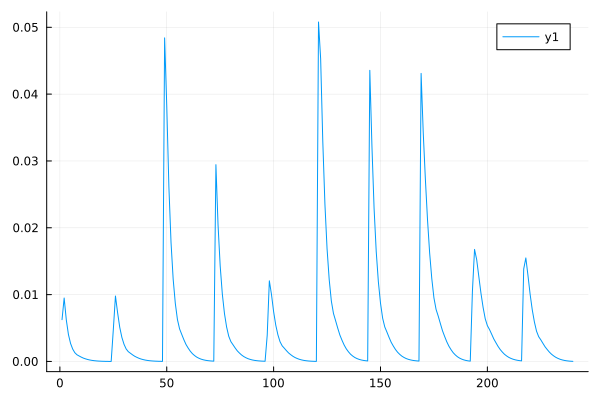

In [26]:
using Plots
plot(diag(abs.(cov_tot - C_mod) / cov_tot))

In [15]:
npzwrite("../data/DESY1/Nzs/cov_marg.npz",
        Dict("TPT0" => TT0, "TPT1" => TT1,
             "TPT2" => TT2, "TPT3" => TT3,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

## Likelihood

In [3]:
pars = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
         1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
        -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
         2.389208e-01,   -6.435288e-01, 
         1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
        -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
         8.536883e-01,    2.535825e-01];

In [4]:
function get_cls(Ωm, s8;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]

    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;


In [5]:
function get_Xi2(Ωm, s8;
                 data_vector=data_vector,
                 inv_cov=inv_cov_tot)

        nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    

    Ωb = pars[1]
    h = pars[5]
    ns = pars[4]
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    
    diff = @.(theory-data_vector)
    return dot(diff, inv_cov * diff)

end

get_Xi2 (generic function with 1 method)

In [6]:
Ωms = LinRange(0.2, 0.6, 10)
s8s = LinRange(0.6, 0.9, 10)

10-element LinRange{Float64, Int64}:
 0.6,0.633333,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9

In [7]:
get_Xi2(pars[26], pars[25])

255.52773157235953

In [44]:
Xi2s_emul = zeros(length(Ωms), length(s8s))
Xi2s_EisHu = zeros(length(Ωms), length(s8s))
for i in 1:length(Ωms)
    for j in 1:length(s8s)
        Xi2s_emul[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="emulator")
        Xi2s_EisHu[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="EisHu")
    end
end

LoadError: UndefVarError: Ωms not defined

In [8]:
n_samples = 100
cls = zeros(240, n_samples)
for i in 1:n_samples
    Ωm = rand(Uniform(0.2, 0.6))
    s8 = rand(Uniform(0.6, 0.9))
    cls[:, i] = get_cls(Ωm, s8)
end

In [9]:
npzwrite("Nz_cls.npz", Dict("cls" => cls))

## Turing

In [46]:
chain = sample(model(fake_data), NUTS(adaptation, TAP, ),
               MCMCDistributed(), iterations, nchains, progress=true; save_state=true)

LoadError: UndefVarError: fake_data not defined